# Lab 4: Trees and Forests

In this assignment, you will explore tree-based classification models to implement predictions for broadband deployment, using a combination of available datasets from the Census and the Federal Communications Commission (FCC).

You will work with these datasets to understand the nature of broadband deployment across Chicago, as well as what features turn out to be good predictors of broadband deployment. The existence of connectivity in a certain area can also be measured in a variety of ways (e.g., available speed tiers, subscriptions, measured performance), and reported in different ways (e.g., by ISPs, by citizens/subscribers). You will explore how reporting and characteristics vary across different datasets and how this may affect your model.

## Learning Objectives

In this assignment, you will learn the following:
* The mechanisms of decision trees and bootstrapping methods, including Random Forest classifiers
* How to work with various broadband connectivity data (ACS, FCC, etc.)
* How to apply tree-based classification models to data (decision tree, Random Forest)
* How to take advantage of various characteristics of Random Forest models, such as feature importance
* How to evaluate classification models using various metrics and approaches 

## Part 2: Loading and Exploring Datasets 

### 2.1 FCC Broadband Map Data

The FCC makes its data for broadband maps available on [its website](https://broadbandmap.fcc.gov). Data is also [available for download](https://broadbandmap.fcc.gov/#/data-download). Internet service providers are required to fill out a "Form 477", which reports service offerings in each Census Block.  

The specific data that we will use for this lab is from June 2019 in Cook County, IL. [API documentation](https://dev.socrata.com/foundry/opendata.fcc.gov/sgz3-kiqt).

In [3]:
import pandas as pd
from sodapy import Socrata

client = Socrata("opendata.fcc.gov", None)

results = client.get("sgz3-kiqt", limit=800000, where="starts_with(blockcode, '17031')")

fcc_df = pd.DataFrame.from_records(results)

print(fcc_df.shape)
fcc_df.head(2)

(794141, 17)


,logrecno,provider_id,frn,providername,dbaname,holdingcompanyname,hoconum,hocofinal,stateabbr,blockcode,techcode,consumer,maxaddown,maxadup,business,maxcirdown,maxcirup
0,30711465,53209,0021890777,"Skybeam, Inc.",Skybeam,"JAB Wireless, Inc.",140048,"JAB Wireless, Inc.",IL,170318254002030,70,1,15,15,1,15,15
1,30711466,53209,0021890777,"Skybeam, Inc.",Skybeam,"JAB Wireless, Inc.",140048,"JAB Wireless, Inc.",IL,170318241204002,70,1,15,15,1,15,15


First, collect your geographic information and merge the data then produce the following three maps for the City of Chicago:
1. The maximum contractual downstream speed offered by any provider in each Census block group.
2. The number of unique ISPs that offer service in each Census block group.
3. The number of unique ISPs that offer service at or above 25 Mbps downstream and 3 Mbps upstream in each Census block group. (This is the FCC's definition of broadband Internet access, which you can read about more in the [2019 broadband deployment report](https://docs.fcc.gov/public/attachments/FCC-19-44A1.pdf)). Use contractual downstream and upstream speed.


In [84]:
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt

fcc_gdf = gpd.GeoDataFrame(fcc_df)
blocks_gdf = gpd.read_file('block_boundaries.geojson') # Available on the Chicago Open Data Portal
blocks_gdf['blockcode'] = blocks_gdf['geoid10']
blocks_gdf['blockgroup_id'] = blocks_gdf['blockcode'].str.slice(stop=-3)

fcc_blocks = fcc_gdf.merge(blocks_gdf, on='blockcode')
fcc_blocks['maxcirdown'] = fcc_blocks['maxcirdown'].astype('float')
fcc_blocks['maxcirup'] = fcc_blocks['maxcirup'].astype('float')
isp_full = fcc_blocks.groupby('blockgroup_id')['provider_id'].nunique().to_frame().rename(
           columns={'provider_id':'number_isps'})
fcc_block_map2 = fcc_blocks.merge(fcc_blocks.groupby('blockgroup_id')['provider_id'].nunique().to_frame(),
                   how='left', on='blockgroup_id').rename(columns={'provider_id_y':'number_isps'})
fcc_broadband = fcc_blocks[(fcc_blocks.maxcirdown>=25) & (fcc_blocks.maxcirup>=3)]
fcc_block_map3 = fcc_block_map2.merge(fcc_broadband.groupby('blockgroup_id')['provider_id'].nunique().to_frame(),
                 how='left', on='blockgroup_id').rename(columns={'provider_id':'broadband_isps'})
# census geo hierachy ref: https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html 
gdf = fcc_block_map3.dissolve(by='blockgroup_id', aggfunc='max') 
gdf['broadband_isps'].fillna(0, inplace=True)


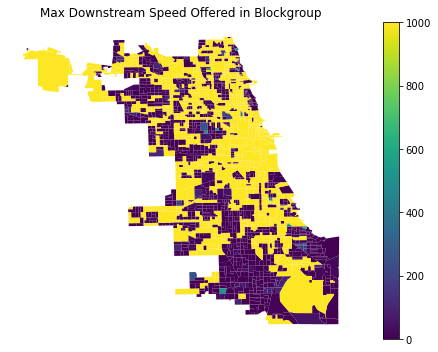

In [90]:
fig, ax = plt.subplots(figsize=(8, 5))

gdf.plot(column='maxcirdown', ax=ax)
ax.axis('off')
ax.set_title('Max Downstream Speed Offered in Blockgroup')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=gdf.maxcirdown.min(), 
                                              vmax=gdf.maxcirdown.max()))
cbar = fig.colorbar(sm)

plt.tight_layout()
plt.show()

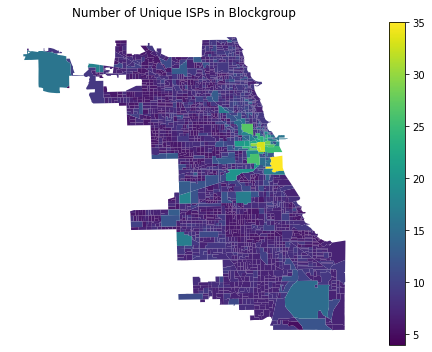

In [94]:
fig, ax = plt.subplots(figsize=(8, 5))
gdf.plot(column='number_isps', ax=ax)
ax.axis('off')
ax.set_title('Number of Unique ISPs in Blockgroup')
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=gdf.number_isps.min(),
                                              vmax=gdf.number_isps.max()))
cbar = fig.colorbar(sm)
plt.tight_layout()
plt.show()

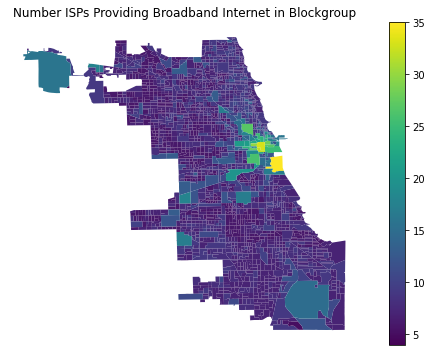

In [96]:
fig, ax = plt.subplots(figsize=(8, 5))
gdf.plot(column='number_isps', ax=ax)
ax.axis('off')
ax.set_title('Number ISPs Providing Broadband Internet in Blockgroup')
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=gdf.number_isps.min(),
                                              vmax=gdf.number_isps.max()))
cbar = fig.colorbar(sm)
plt.tight_layout()
plt.show()

### 2.2 ACS Data

Use the Census API to perform the following for block groups in the City of Chicago:
1. Load ACS data for the following field: 
    * the percentages of broadband Internet access of any type
2. Load ACS data for Total Population, White, Black, and Median Income – and then compute the following: 
    * the percentage of each Census block group's population that is White and Black; 
    * the median income for the block gloup; 
    * the population density of the block group (e.g. in units of population per square kilometer) 
    

In [5]:
import censusdata

census_tables = {
    'GEO_ID': 'GEO_ID', 
    'B28011_001E': 'Internet Total', 
    'B28011_004E': 'Broadband', 
    'B02001_001E': 'Race Total', 
    'B02001_002E': 'White', 
    'B02001_003E': 'Black', 
    'B19013_001E': 'Median Income'}

acs_df = censusdata.download("acs5", 
                              2018, 
                              censusdata.censusgeo([("state", "17"), 
                                                    ("county", "031"),
                                                    ("tract", "*"),
                                                    ("block group", "*")]), 
                              list(census_tables.keys()))


acs_df.rename(columns=census_tables, inplace=True)

print(acs_df.shape)
acs_df.head(2)

(3993, 7)


,GEO_ID,Internet Total,Broadband,Race Total,White,Black,Median Income
"Block Group 1, Census Tract 8088, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:808800> block group:1",1500000US170318088001,788,690,1738,1538,70,96111
"Block Group 2, Census Tract 8088, Cook County, Illinois: Summary level: 150, state:17> county:031> tract:808800> block group:2",1500000US170318088002,601,516,1994,1672,39,173646


In [97]:
blockgroups = blocks_gdf.dissolve(by='blockgroup_id').reset_index()
blockgroups.crs = "EPSG:4326"

acs_df['blockgroup_id'] = acs_df['GEO_ID'].apply(lambda x: x[9:])
acs_gdf = blockgroups.merge(acs_df, on='blockgroup_id')

acs_gdf['Area'] = acs_gdf.to_crs('EPSG:3857').area / (10**6)
acs_gdf['Population Density'] = acs_gdf['Race Total'] / acs_gdf['Area']
acs_gdf['Percent White'] = acs_gdf['White'] / acs_gdf['Race Total']
acs_gdf['Percent Black'] = acs_gdf['Black'] / acs_gdf['Race Total']


acs_gdf.head(5)

,blockgroup_id,geometry,statefp10,name10,blockce10,tract_bloc,geoid10_x,tractce10,countyfp10,blockcode,...,Broadband,Race Total,White,Black,Median Income,Percent White,Percent Black,geoid10_y,Area,Population Density
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",17,Block 1000,1000,0101001000,170310101001000,010100,031,170310101001000,...,180,491,279,143,-666666666,0.568228,0.291242,170310101001,0.113260,4335.157136
1,170310101002,"POLYGON ((-87.66950 42.01936, -87.66963 42.019...",17,Block 2002,2002,0101002002,170310101002002,010100,031,170310101002002,...,379,2197,766,1389,21222,0.348657,0.632226,170310101002,0.334453,6568.937237


In [188]:
final_gdf = gdf.merge(acs_gdf.set_index('blockgroup_id'), left_index=True, right_index=True)

## Part 3: Prediction with Tree-Based Models
### 3.1 Decision Trees
#### 3.1.1 Training Decison Trees

First, train a decision tree classifier to predict if a Census block group has broadband Internet access or not (i.e., at least one ISP that offers service at or above 25 Mbps downstream and 3 Mbps upstream). Tune your classifier with a hyperparameter grid and use k-fold cross validation. 

In the previous lab, you were asked to construct hyperparameter grids and manually send data through the pipeline. For this lab, you may use scikit-learn's inbuilt `Pipeline` and `GridSearchCV` objects to simplify this step. 

Print a dataframe summarizing your grid search results. This should have one row for each classifier that you trained (18 total rows) specifying the hyperparamters for that classifier along with its evaluation metrics averaged across the folds (accuracy, precision, and recall). 

In [232]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

final_gdf['target'] = final_gdf.broadband_isps.apply(lambda x: 1 if x > 0 else 0)
target = final_gdf['target']
features = final_gdf[['Median Income', 'Percent White', 'Percent Black', 'number_isps', 'Population Density']]
labels = list(features.columns)
#Split data and impute missing values
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.30, 
                                                    random_state=0)
X_train['Median Income'] = X_train['Median Income'].apply(lambda x: np.nan if x == -666666666 else x)
med_medinc = X_train['Median Income'].median()
X_train['Median Income'] = X_train['Median Income'].fillna(med_medinc)
X_test['Median Income'] = X_test['Median Income'].fillna(med_medinc)

med_perwhite, med_perblack = (X_train['Percent White'].median(), X_train['Percent Black'].median())
X_train['Percent White'] = X_train['Percent White'].fillna(med_perwhite)
X_test['Percent White'] = X_test['Percent White'].fillna(med_perwhite)
X_train['Percent Black'] = X_train['Percent Black'].fillna(med_perblack)
X_test['Percent Black'] = X_test['Percent Black'].fillna(med_perwhite)

#build pipeline and tune hyperparameters
pipe = Pipeline([('scale', StandardScaler()), ('tree', DecisionTreeClassifier(random_state=0))])
params = {'tree__criterion': ['gini', 'entropy'],
              'tree__max_depth': [1, 3, 5],
              'tree__min_samples_split':[2, 5, 10]}
kf = KFold(n_splits=10, shuffle=True, random_state=0)
score_list = ['accuracy', 'precision', 'recall']
grid = GridSearchCV(pipe, param_grid=params, cv=kf, scoring=score_list, refit='accuracy')
model_result = grid.fit(X_train, y_train)
score_df = pd.DataFrame(model_result.cv_results_)[['params', 'mean_test_accuracy',
                                                   'mean_test_precision', 'mean_test_recall']]
score_df.sort_values(by=['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall'], ascending=False)



<ipython-input-232-7e6bf54f9b3e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Median Income'] = X_train['Median Income'].apply(lambda x: np.nan if x == -666666666 else x)
<ipython-input-232-7e6bf54f9b3e>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Median Income'] = X_train['Median Income'].fillna(med_medinc)
<ipython-input-232-7e6bf54f9b3e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

,params,mean_test_accuracy,mean_test_precision,mean_test_recall
0,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.793506,0.836258,0.730984
1,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.793506,0.836258,0.730984
2,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.793506,0.836258,0.730984
9,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.793506,0.836258,0.730984
10,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.793506,0.836258,0.730984
11,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.793506,0.836258,0.730984
6,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.786291,0.767527,0.832208
7,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.785642,0.767247,0.830943
17,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.785642,0.764326,0.835480
8,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.785638,0.767285,0.831059


In [233]:
score_df.loc[0].params

{'tree__criterion': 'gini', 'tree__max_depth': 1, 'tree__min_samples_split': 2}

#### 3.1.2 Evaluation I: Interpreting Trees

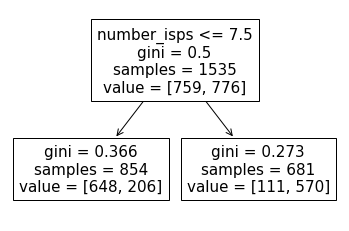

In [234]:
from sklearn.tree import plot_tree

tree = DecisionTreeClassifier(criterion='gini', max_depth=1, min_samples_split=2)
model = tree.fit(X_train, y_train)
plot_tree(model, feature_names=labels);

What was the most important feature in the tree that yielded the highest accuracy? 

We have only one split, meaning that only one feature can contribute to accuracy per tree.  The most important feature was the number of ISPs present in that blockgroup, as shown below

In [235]:

feat_imp = tree.feature_importances_
{labels[i]:feat_imp[i] for i in range(len(feat_imp))}

{'Median Income': 0.0,
 'Percent White': 0.0,
 'Percent Black': 0.0,
 'number_isps': 1.0,
 'Population Density': 0.0}

#### 3.1.3 Evaluation II: Confusion Matrices and Precision-Recall Curves

For all questions in this section, use the decision tree from above that yielded the highest average accuracy. 

Report the confusion matrix for this decision tree. Then use the output of this confusion matrix to manually calculate the following:

1. What is the test precision for this tree?
2. What is the test recall for this tree?
3. What is the test F1 score for this tree? 

After manually computing these metrics, use the built-in `scikit-learn.metrics` functions to verify your answers. 

[[283  54]
 [ 90 232]]


array([[283,  54],
       [ 90, 232]], dtype=int64)

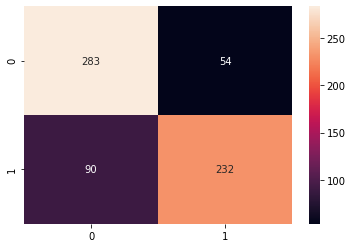

In [236]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
y_pred = tree.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='d')
print(confusion)
confusion_matrix(y_test, y_pred)

In [274]:
fn, fp, fn, tp = 283, 54, 90, 232
precision = tp/(tp + fp)
recall = tp/(tp + fn)
f1 = 2*recall*precision/(recall+precision)

check = (f1 == f1_score(y_test, y_pred)
         and precision == precision_score(y_test, y_pred)
         and recall == recall_score(y_test, y_pred))
if check:
    print('precision: {}, recall: {}, f1: {}'.format(precision, recall, f1))
else:
    print('sklearn and manual calculations do not all match')

precision: 0.8111888111888111, recall: 0.7204968944099379, f1: 0.763157894736842


Plot the precision-recall curve for this decision tree. Then answer the following questions:

1. Describe what you observe in the precision-recall curve in plain language.
2. Does it make sense for precision to decrease as recall increases? Why or why not? 
3. Can you identify a 'sweet spot' in the graph? (i.e., a threshold that balances nicely precision and recall)

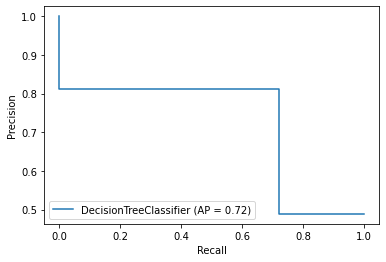

In [237]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(tree, X_test, y_test)

1) Given that this tree is only one level, it looks like a step function.  However, we can still glean that there appears to be some negative relationship between precision and recall, which is usually the case.

2) Yes, one punishes false negatives and one punishes false positives.  It makes sense that we would see a trade-off.

3) The sweet-spot on this is fairly clear.  It is where precision is roughly equal to 0.8 and recall is roughly equal to 0.7.

#### 3.1.4 Subsetting Features
Note that the number of ISPs is closely (and directly) related to the predicted outcome. Suppose you no longer have access to the FCC data. Re-run your decision tree classification using just the ACS demographic features. How does this model perform compared to the model including the number of ISPs as a predictor? 

In [231]:
X_train_less_fcc = X_train[['Median Income', 'Percent White', 'Percent Black', 'Population Density']]
X_test_less_fcc = X_test[['Median Income', 'Percent White', 'Percent Black', 'Population Density']]
model_less_fcc = grid.fit(X_train_less_fcc, y_train)
score_df = pd.DataFrame(model_less_fcc.cv_results_)[['params', 'mean_test_accuracy',
                                                   'mean_test_precision', 'mean_test_recall']]
score_df.sort_values(by=['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall'], ascending=False).head(3)

,params,mean_test_accuracy,mean_test_precision,mean_test_recall
0,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.582321,0.562877,0.769891
1,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.582321,0.562877,0.769891
2,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.582321,0.562877,0.769891


In [219]:
#best parameters
score_df.loc[3].params

{'tree__criterion': 'gini', 'tree__max_depth': 3, 'tree__min_samples_split': 2}

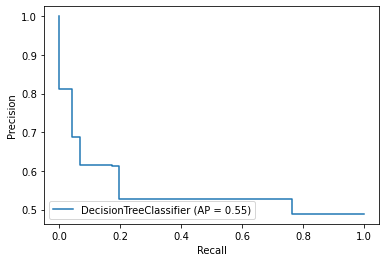

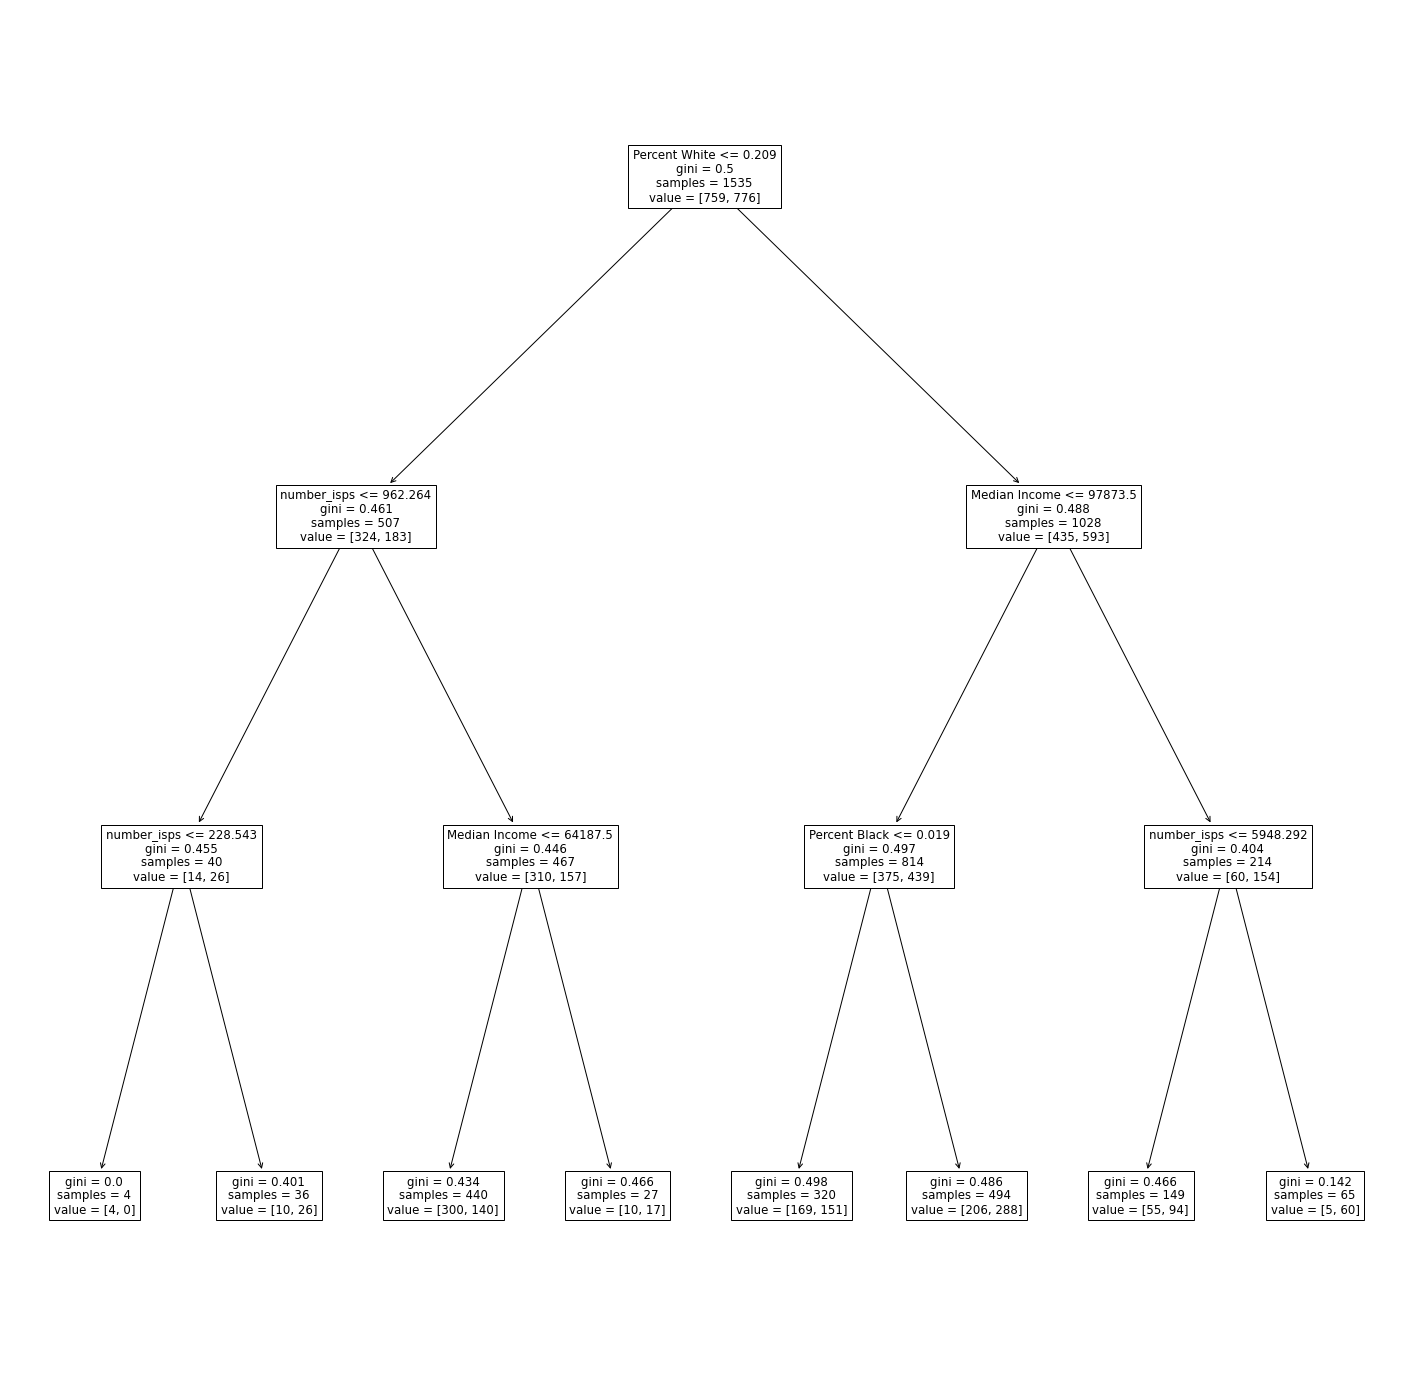

In [227]:
tree_lessfcc = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=2)
model_lessfcc = tree_lessfcc.fit(X_train_less_fcc, y_train)
plot_precision_recall_curve(tree_lessfcc, X_test_less_fcc, y_test)
plt.figure(figsize=(25,25))
plot_tree(model_lessfcc, feature_names=labels);

In [238]:
labels2 = ['Median Income', 'Percent White', 'Percent Black', 'Population Density']
feat_imp_lessfcc = tree_lessfcc.feature_importances_
{labels2[i]:feat_imp_lessfcc[i] for i in range(len(feat_imp_lessfcc))}

{'Median Income': 0.22424589643159779,
 'Percent White': 0.4449284569194235,
 'Percent Black': 0.06741097066672141,
 'Population Density': 0.26341467598225743}

This tree performs worse by every metric.  However, it does give us some insight into the other features.  Here, we see that the most important feature is how white a neighborhood is.  While I wouldn't want to use this model, its accuracy is quite low, the recall score is roughly 0.76 and that means we do a relatively good job at avoiding false negatives.  If we could tune the features a bit more and just increase recall, this model could have some uses.

### 3.2 Random Forests

#### 3.2.1 Training Random Forests

Next, train a Random Forest classifier to predict broadband Internet deployment. As before, tune your classifier with a hyperparameter grid and use k-fold cross validation. Again, print a dataframe summarizing the classifiers, the hyperparameters for each classifier, and their respective evaluation metrics.

As with the previous section: 
- You may use scikit-learn's inbuilt `Pipeline` and `GridSearchCV` functions if you prefer.
- Use `random_state=0` when both splitting your data and training your classifiers.
- Given the size of this dataset, it will be sufficient to forgo the validation set and only separate your data into training and testing sets (i.e., use `sklearn.model_selection.test_train_split`)
- Your classifier should use the following features:
    - The ACS population characteristics from Section 2.2 (percentage of population that is White and Black, median income, population density)
    - The number of ISPs serving that block group
- Tune your classifier with a hyperparameter grid, using the following hyperparameter options (note the differences for Random Forests):
    - `n_estimators`: 100, 1000, 5000
    - `criterion`: `gini` or `entropy`
    - `max_depth`: 1, 3, 5
    - `min_samples_split`: 2, 5, 10
- Use K-fold cross validation with `k = 10`, using accuracy as your scoring metric.
- For evaluation metrics, print accuracy, precision, and recall on the test set for each hyperparameter combination.

**Note:** This will take noticeably longer than training the single decision tree, but should not exceed 40 minutes. We highly recommend creating a smaller sample of this data to work with while you test your code. 

In [239]:
pipe_rf = Pipeline([('scale', StandardScaler()), ('tree', RandomForestClassifier(random_state=0))])
params_rf = {'tree__n_estimators': [100, 1000, 5000],
             'tree__criterion': ['gini', 'entropy'],
             'tree__max_depth': [1, 3, 5],
             'tree__min_samples_split':[2, 5, 10]}
kf_rf = KFold(n_splits=10, shuffle=True, random_state=0)
score_list_rf = ['accuracy', 'precision', 'recall']
grid_rf = GridSearchCV(pipe_rf, param_grid=params_rf, cv=kf_rf, scoring=score_list_rf, refit='accuracy')
model_result_rf = grid_rf.fit(X_train, y_train)

,params,mean_test_accuracy,mean_test_precision,mean_test_recall
52,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.810449,0.813817,0.806767
49,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.810445,0.814538,0.805315
46,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.809787,0.812482,0.806448
53,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.808488,0.812276,0.804216
22,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.807852,0.819811,0.789900
50,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.807839,0.812027,0.802950
47,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.807190,0.809960,0.804266
19,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.806544,0.817561,0.789900
45,"{'tree__criterion': 'entropy', 'tree__max_dept...",0.806540,0.809019,0.803970
20,"{'tree__criterion': 'gini', 'tree__max_depth':...",0.805899,0.818111,0.787332


In [251]:
score_df_rf = pd.DataFrame(model_result_rf.cv_results_)[['param_tree__criterion', 'param_tree__max_depth',
                                           'param_tree__min_samples_split', 'param_tree__n_estimators',
                                           'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]
score_df_rf.sort_values(by=['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall'], ascending=False)

,param_tree__criterion,param_tree__max_depth,param_tree__min_samples_split,param_tree__n_estimators,mean_test_accuracy,mean_test_precision,mean_test_recall
52,entropy,5,10,1000,0.810449,0.813817,0.806767
49,entropy,5,5,1000,0.810445,0.814538,0.805315
46,entropy,5,2,1000,0.809787,0.812482,0.806448
53,entropy,5,10,5000,0.808488,0.812276,0.804216
22,gini,5,5,1000,0.807852,0.819811,0.789900
50,entropy,5,5,5000,0.807839,0.812027,0.802950
47,entropy,5,2,5000,0.807190,0.809960,0.804266
19,gini,5,2,1000,0.806544,0.817561,0.789900
45,entropy,5,2,100,0.806540,0.809019,0.803970
20,gini,5,2,5000,0.805899,0.818111,0.787332


#### 3.2.2 Evaluation I: Interpreting Random Forests

Identify the Random Forest with the highest average test accuracy. Create a plot showing feature importance. 

In [254]:
score_df_rf.loc[52]

param_tree__criterion             entropy
param_tree__max_depth                   5
param_tree__min_samples_split          10
param_tree__n_estimators             1000
mean_test_accuracy               0.810449
mean_test_precision              0.813817
mean_test_recall                 0.806767
Name: 52, dtype: object

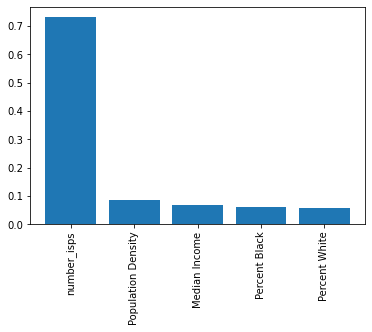

In [265]:
tree_rf = RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=10, n_estimators=1000)
model_rf = tree_rf.fit(X_train, y_train)

importances = model_rf.feature_importances_

# Sort in descending order
indices = np.argsort(importances)[::-1]

# Sort the labels in a corresponding fashion
labels = list(X_train.columns)
names = [labels[i] for i in indices]

# Plot
plt.figure()
plt.bar(range(features.shape[1]),importances[indices])
plt.xticks(range(features.shape[1]), names, rotation=90)
plt.show()

#### 3.2.3 Evaluation II: Confusion Matrices and Precision Recall Curves

For all questions in this section, use the Random Forest classifier that yielded the highest average accuracy. 

Report the confusion matrix for this Random Forest classifier using the test data. Then manually calculate the following (and feel free to then check your work with the built-in functions):

1. What is the test precision for this classifier?
2. What is the test recall for this classifier?
3. What is the test F1 score for this classifier? 

How do these figures compare to the test metrics for the decision tree?

array([[267,  70],
       [ 61, 261]], dtype=int64)

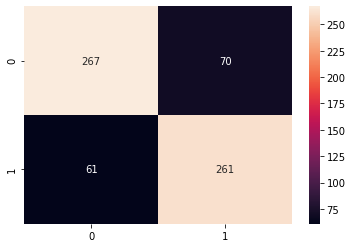

In [266]:
y_pred_rf = tree_rf.predict(X_test)
confusion_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(confusion_rf, annot=True, fmt='d')
confusion_rf

In [273]:
fn_rf, fp_rf, fn_rf, tp_rf = 267, 70, 61, 261
precision_rf = tp_rf/(tp_rf + fp_rf)
recall_rf = tp_rf/(tp_rf + fn_rf)
f1_rf = 2*recall_rf*precision_rf/(recall_rf+precision_rf)

print('precision: {}, recall: {}, f1: {}'.format(precision_rf, recall_rf, f1_rf))

precision: 0.7885196374622356, recall: 0.8105590062111802, f1: 0.7993874425727412


The values are much more balanced, we were essentially able to avoid trading precision for recall by making more classifications that were true positives and negatives.  It did not have a large effect on our overall accuracy.

Plot the precision-recall curve for this Random Forest. On the same axes, plot the precision-recall curve for the decision tree that you previously plotted in Section 3.1.3. How do they compare? Which would you choose if you wanted to maximize precision? What if you wanted to maximize recall?

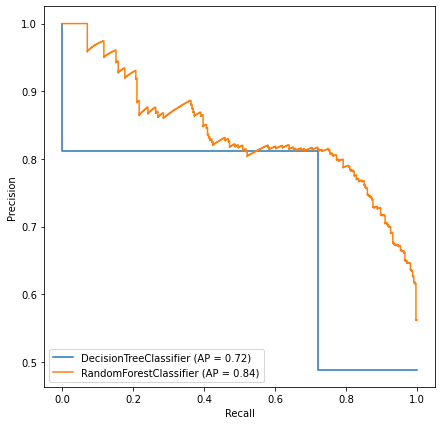

In [323]:
f, ax = plt.subplots(figsize=(7, 7))
plot_precision_recall_curve(tree, X_test, y_test, ax=ax);
plot_precision_recall_curve(tree_rf, X_test, y_test, ax=ax);
plt.show() 

Given that the random forest is an ensemble and not just a single tree, we see that its curve looks more like a traditional curve and not a stepwise function.  It has comparably smooth tradeoffs.  From this visualization, I would use the Random Forest for maximizing either precision or recall.  The decision tree does a decent job, but the random forest can do better at both

### 3.3 Policy Applications and Model Selection

Imagine you have been hired by the City of Chicago, who is administering a survey about broadband quality. However, they do not know which block groups have broadband and must choose a model to predict broadband deployment. 

1. It is important for you to reach as many block groups with broadband as possible without visiting every single block group. Of the classifiers you trained above, which should you use to predict broadband deployment in this situation? Why?
2. Budget cuts have struck! Priorities have shifted, and you are now told that you can only survey a small number of block groups. You are not worried about representativeness, and your main goal is to avoid wasting resources by visiting block groups that do not have broadband. Which classifier do you use now? Why?
3. You find out only after training that your population density data was in units of people per square mile, not people per square kilometer, meaning that your data would need to be rescaled to be properly interpreted. Do you now need to retrain your model with the rescaled data to get an updated set of predictions? Why or why not?
4. The City of Chicago is interested in better understanding the predictive features in your model. Why do you think the number of ISP providers and population density are important predictors? 

There is a deep policy debate around broadband access related to the role of public investment, public-private-partnerships, and subsidies. This includes a discussion of 'rate-of-return' carriers and what ISPs should be allowed to charge for broadband access in rural areas. For further reading, see [this discussion](https://www.usac.org/high-cost/resources/rules-orders/rate-of-return-reform-order/) on rate-of-return reform and this [FCC briefing](https://docs.fcc.gov/public/attachments/FCC-19-77A1.pdf). 

1)
I am reading this to mean that we are okay visiting some false positives.  In that case, I would use the random forest.  We want high accuracy here, but also care a lot about recall, because we want to minimize ignoring false negatives. The more accuracte the model, the more true positives we have and the higher the recall, the less false negatives we have.  

2)
Here we care mostly about precision.  We do not want to spend our time at false positives and waste resources, so our best model is our original decision tree classifier. 

3)
I do not think you need to retrain your model, because correcting the feature would simply scale every value by the same factor.  The normalized versions of population per square mile and population per square kilometer will be equal, because the correction only entails a linear transformation.

4)
I think they are important predictors of broadband because they are important predictors of competition.  The train of thought is that more highly populated areas will generally have more ISPs competing for their business.  However, there are other factors at play, which is why the number of ISPs itself is so important.  It is evidence of competition and, if they are competing for market share, it seems reasonable to assume that at least one ISP will offer quality internet that meets the FCC guidelines for broadband in an effort to distinguish themselves.

### 3.4 Working with Thresholds

#### 3.4.1 Thresholds I: Fixed Values Approach
Use the following fixed values to convert probability scores (the output of `predict_proba`) into binary predictions: 0, 0.3, 0.5, 0.7, 0.9. Output a table summarizing the precision and recall at each of these thresholds. 

In [291]:
from sklearn.metrics import accuracy_score
thresholds = [0, 0.3, 0.5, 0.7, 0.9]
thresholds_dict = {}
for i in thresholds:
    predicted_proba = tree_rf.predict_proba(X_test)
    predicted = (predicted_proba [:,1] >= i).astype('int')
    recall = recall_score(y_test, predicted)
    precision = precision_score(y_test, predicted)
    thresholds_dict[i] = {'recall':recall, 'precision':precision}
pd.DataFrame(thresholds_dict)

,0.0,0.3,0.5,0.7,0.9
recall,1.000000,0.978261,0.810559,0.60559,0.127329
precision,0.488619,0.646817,0.788520,0.81590,0.953488


#### 3.4.2 Thresholds II: Percentage Approach

Now, use the percentage-based approach using the following threshold percentages: 1%, 5%, 10%, 20%, 50% 100%. 

Using the 1% threshold, for example, you would need to output probability scores for each observation, sort these probabilities in descending order based on this score, and then assign the top 1% True (and the bottom 99% False). If your dataset had 1,000 observations, that would mean that just 10 observations would be marked True. 

Again, output a table summarizing the precision and recall at each of these thresholds. 

In [320]:
import math
thresholds = [0.01, 0.05, 0.1, 0.2, 0.5,1]
thresholds_dict = {}
for i in thresholds:
    predicted_proba = tree_rf.predict_proba(X_test)
    predicted = predicted_proba[predicted_proba[:,1].argsort()[::-1]]
    predicted[0:math.floor(len(predicted_proba)*i), 1] = 1
    predicted[math.floor(len(predicted_proba)*i):, 1] = 0
    predicted = predicted[:,1]
    recall = recall_score(y_test, predicted)
    precision = precision_score(y_test, predicted)
    thresholds_dict[i] = {'recall':recall, 'precision':precision}
pd.DataFrame(thresholds_dict)

,0.01,0.05,0.10,0.20,0.50,1.00
recall,0.003106,0.037267,0.105590,0.208075,0.506211,1.000000
precision,0.166667,0.375000,0.523077,0.511450,0.495441,0.488619


#### 3.4.3 Summarizing Thresholds

Describe what you observed in the two summary tables above. How do precision and recall change when adjusting the thresholds using the two approaches? Are these results consistent with your precision-recall curves? Discuss a situation when using a threshold approach would make sense when evaluating classification models. 

Using a fixed probability threshold, we see the familiar trade off between recall and precision.  This makes sense, since the thresholds are related directly to the probability that it is true.  So, we are doing more to directly invite false positives and false negatives in opposition to one another.  However, with the percentage thresholds, we do not see the same behavior.  It isn't what I expected, but it does still make sense.  Here, we simply taken the top x percent regardless of the probability the predicted value is true.  So, it makes sense that they aren't directly related.  Of course, as we raise the threshold of percent to include, recall will steadily climb to one, while precision will be less predictable.

One area you could use a threshold approach is when precision is very important.  For example, if we were to use an algorithm to decide whether a person charged with a crime was a danger to society and should be denied bail, you could use a static probability threshold.  If this algorithm is going to have any level of input into the decision to deny bail, the threshold would have to be extremely high, because false positives in this scenario are extremely dangerous to the accused and the integrity of the justice system.

For the record, I don't think that is a good use of an algorithm, but it is analogous to some real world uses.